# TDF, alias y otro artefactos

Desarrollaremos la interpretación de la obtención del a TDF a partir de una señal muestreada, su relación con la TCF y los artefactos como el alias y el rizado que pueden presentarse por este proceso.

Tenemos una señal $x(t)$ **continua de duración infinita** y con TCF limitada en banda (a partir de cierta $f_{max}$ no tiene energía). Queremos muestrear dicha señal continua, para lo cual la multiplicamos por un tren de impulsos $\Delta(t)$ espaciados por un valor T. En el dominio frecuencia, el efecto de multiplicar en el tiempo es equivalente a una convolución entre la TCF de $x(t)$ y la del tren de impulsos. Pero la TCF de un tren de impulsos espaciados por T es otro tren de impulsos espaciados por $1/T$

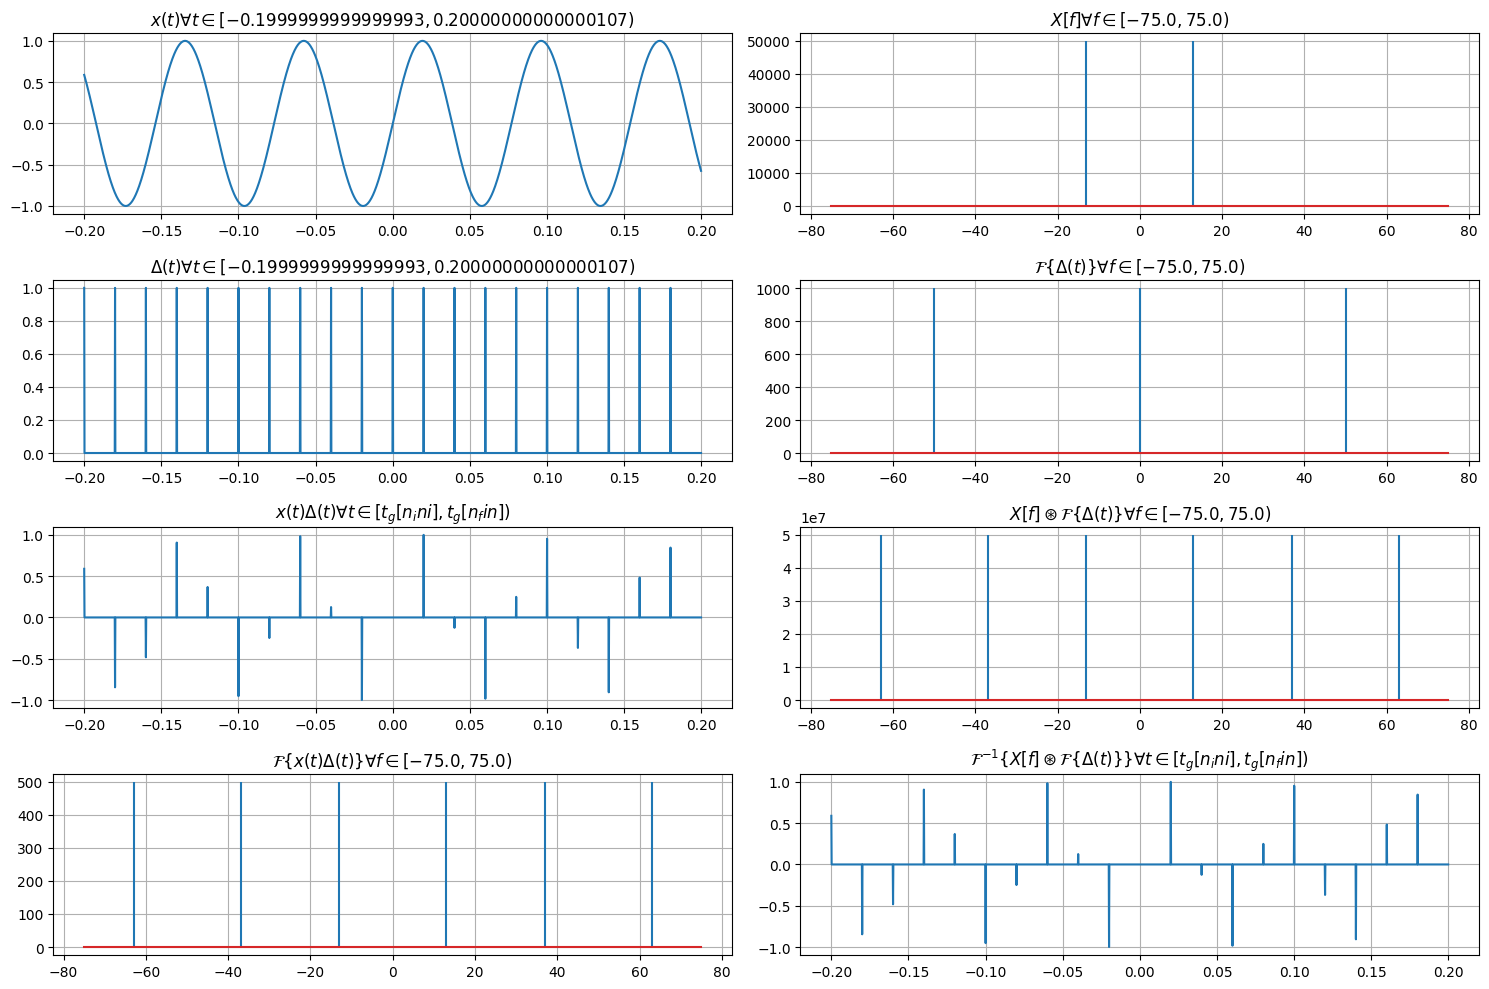

In [71]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

def s(t,f=13,fase=0):
    '''Senial continua definida como funcion'''
    #return 1 / (1 + np.abs(t))
    return np.sin(2*np.pi*t*f+fase)

def delta(t,T):
    '''Tren de impulsos de intervalo T'''
    pulses = np.zeros_like(t, dtype=int)

    # Calculate start and end pulse numbers
    k_min = int(np.floor(t[0] / T))
    k_max = int(np.ceil(t[-1] / T))

    # Generate the pulse times
    pulse_times = np.arange(k_min, k_max + 1) * T

    # For each pulse time, find the closest index in t
    for tp in pulse_times:
        idx = (np.abs(t - tp)).argmin()
        pulses[idx] = 1
    return pulses

# Parametros
Tini = -10
Tfin = 10
fm = 50                         # frecuencia del tren de impulsos
fm_g = fm*100                   # frecuencia de muestreo
[k_ini,k_fin] = [-1500,1500]      # rango de la grafica en frecuencias

# t para graficar
t_g = np.linspace(Tini,Tfin,int(fm_g*(Tfin-Tini)), endpoint=False)
N_g = len(t_g)
[n_ini, n_fin] = [int(N_g/2)-1000, int(N_g/2)+1000]  # rango de la grafica en tiempo

# senial
x = s(t_g)

# Tren de impulsos
delta_g = delta(t_g,1.0/fm)

# fourier para TCF
tcf_s = np.fft.fft(x)
tcf_delta = np.fft.fft(delta_g)
fc = np.fft.fftfreq(N_g, 1/fm_g)
tcf_s_g = np.concatenate([tcf_s[:k_fin],tcf_s[N_g+k_ini:]]) # espectro acotado
tcf_delta_g = np.concatenate([tcf_delta[:k_fin],tcf_delta[N_g+k_ini:]]) # espectro acotado
fc_g = np.concatenate([fc[:k_fin],fc[N_g+k_ini:]])

# convolucion en frecuencia
tcf_conv = np.fft.ifft(np.fft.fft(tcf_s) * np.fft.fft(tcf_delta))       # convolucion transformando, multiplicando y antitransformando
tcf_conv_g = np.concatenate([tcf_conv[:k_fin],tcf_conv[N_g+k_ini:]]) # espectro acotado

# multiplicacion en tiempo
mult = np.multiply(x,delta_g)

# anti dft de la convolucion en frecuencia
idft_tcf_conv = np.fft.ifft(tcf_conv)*(1/N_g)

# dft de la multiplicacion en tiempo
dft_mult = np.fft.fft(mult)
dft_mult_g = np.concatenate([dft_mult[:k_fin],dft_mult[N_g+k_ini:]]) # espectro acotado

fig = plt.figure()
ax = [
    plt.subplot2grid([4,2],[0,0]),
    plt.subplot2grid([4,2],[0,1]),
    plt.subplot2grid([4,2],[1,0]),
    plt.subplot2grid([4,2],[1,1]),
    plt.subplot2grid([4,2],[2,0]),
    plt.subplot2grid([4,2],[2,1]),
    plt.subplot2grid([4,2],[3,0]),
    plt.subplot2grid([4,2],[3,1]),
]
fig.set_figheight(10)
fig.set_figwidth(15)
for axi in ax:
    axi.grid()

# s
ax[0].plot(t_g[n_ini:n_fin], x[n_ini:n_fin])
ax[0].set_title(f"$x(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$")
# fft s
ax[1].stem(fc_g,np.abs(tcf_s_g), markerfmt="")
ax[1].set_title(f"$X[f] \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# impulsos
ax[2].plot(t_g[n_ini:n_fin],delta_g[n_ini:n_fin])
ax[2].set_title(f"$\\Delta(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$")
# fft impulsos
ax[3].stem(fc_g,np.abs(tcf_delta_g), markerfmt="")
ax[3].set_title(f"$\\mathcal{{F}} \\{{ \\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# multiplicacion en tiempo
ax[4].plot(t_g[n_ini:n_fin],mult[n_ini:n_fin])
ax[4].set_title('$x(t)\\Delta(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$')
# convolucion en frecuencias
ax[5].stem(fc_g,np.abs(tcf_conv_g), markerfmt="")
ax[5].set_title(f"$X[f]\\circledast \\mathcal{{F}} \\{{\\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# dft de la multiplicacion en tiempo
ax[6].stem(fc_g,np.abs(dft_mult_g), markerfmt="")
ax[6].set_title(f"$\\mathcal{{F}} \\{{ x(t)\\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# anti dft de la convolucion en frecuencia
ax[7].plot(t_g[n_ini:n_fin], idft_tcf_conv[n_ini:n_fin])
ax[7].set_title('$\\mathcal{F}^{-1} \\{{ X[f]\\circledast \\mathcal{F} \\{{ \\Delta(t) \\}} \\}} \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$')
fig.tight_layout()

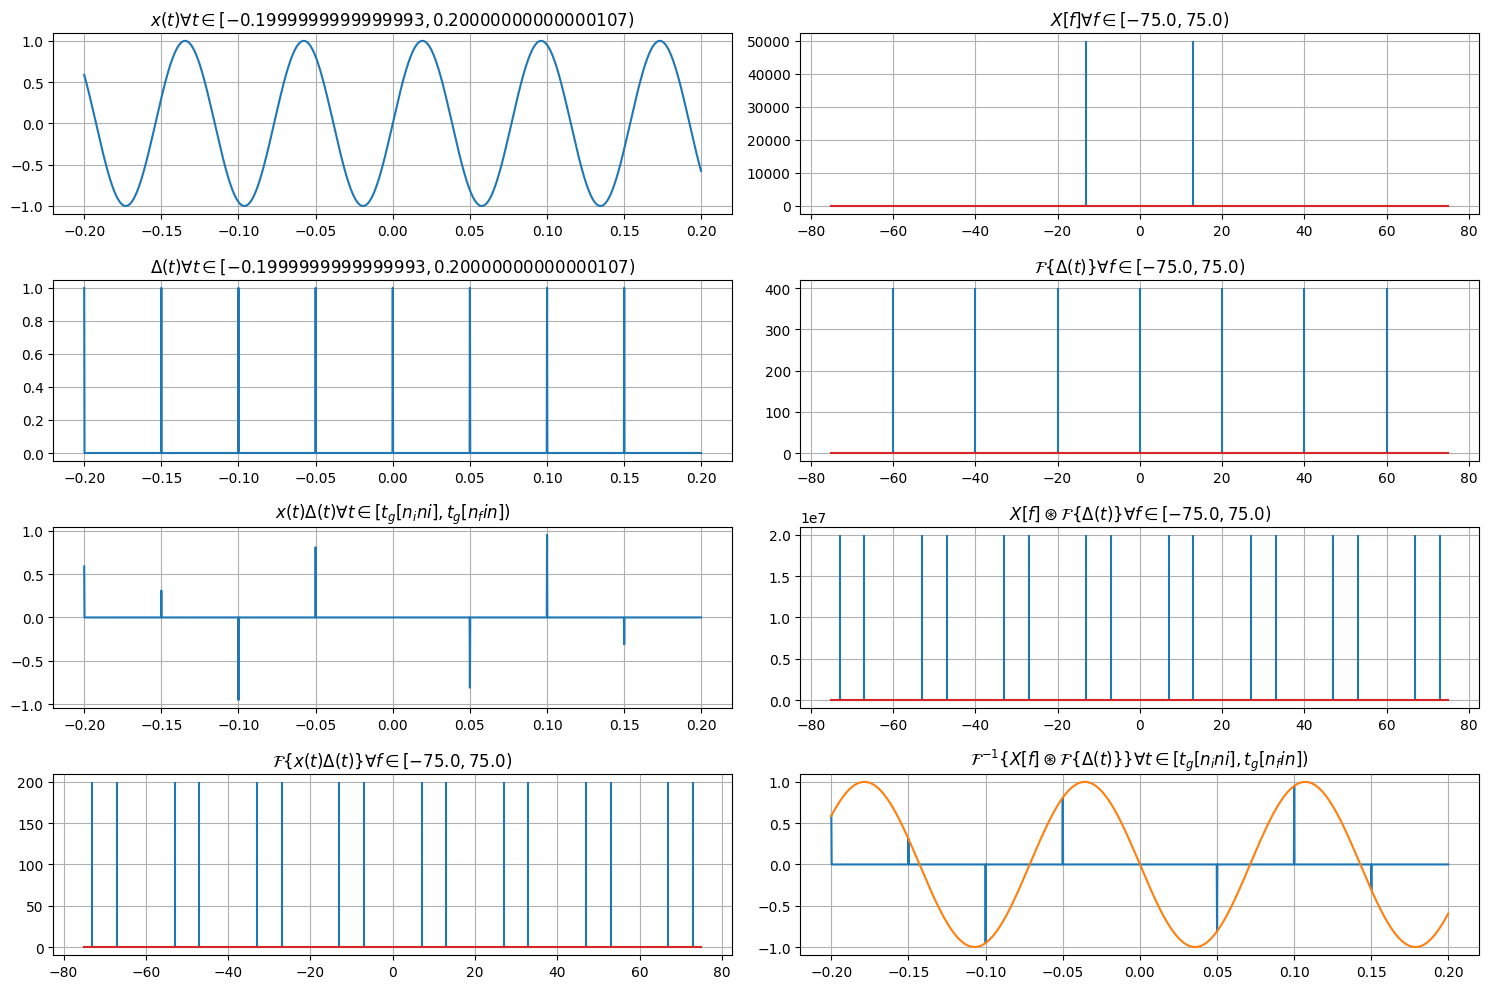

In [ ]:
# Parametros
Tini = -10
Tfin = 10
fm = 20                           # frecuencia del tren de impulsos
#fm_g = fm*100                     # frecuencia de muestreo
[k_ini,k_fin] = [-1500,1500]      # rango de la grafica en frecuencias

# t para graficar
t_g = np.linspace(Tini,Tfin,int(fm_g*(Tfin-Tini)), endpoint=False)
N_g = len(t_g)
[n_ini, n_fin] = [int(N_g/2)-1000, int(N_g/2)+1000]  # rango de la grafica en tiempo

# senial
x = s(t_g)

# Tren de impulsos
delta_g = delta(t_g,1.0/fm)

# fourier para TCF
tcf_s = np.fft.fft(x)
tcf_delta = np.fft.fft(delta_g)
fc = np.fft.fftfreq(N_g, 1/fm_g)
tcf_s_g = np.concatenate([tcf_s[:k_fin],tcf_s[N_g+k_ini:]]) # espectro acotado
tcf_delta_g = np.concatenate([tcf_delta[:k_fin],tcf_delta[N_g+k_ini:]]) # espectro acotado
fc_g = np.concatenate([fc[:k_fin],fc[N_g+k_ini:]])

# convolucion en frecuencia
tcf_conv = np.fft.ifft(np.fft.fft(tcf_s) * np.fft.fft(tcf_delta))       # convolucion transformando, multiplicando y antitransformando
tcf_conv_g = np.concatenate([tcf_conv[:k_fin],tcf_conv[N_g+k_ini:]]) # espectro acotado

# multiplicacion en tiempo
mult = np.multiply(x,delta_g)

# anti dft de la convolucion en frecuencia
idft_tcf_conv = np.fft.ifft(tcf_conv)*(1/N_g)

# dft de la multiplicacion en tiempo
dft_mult = np.fft.fft(mult)
dft_mult_g = np.concatenate([dft_mult[:k_fin],dft_mult[N_g+k_ini:]]) # espectro acotado

fig = plt.figure()
ax = [
    plt.subplot2grid([4,2],[0,0]),
    plt.subplot2grid([4,2],[0,1]),
    plt.subplot2grid([4,2],[1,0]),
    plt.subplot2grid([4,2],[1,1]),
    plt.subplot2grid([4,2],[2,0]),
    plt.subplot2grid([4,2],[2,1]),
    plt.subplot2grid([4,2],[3,0]),
    plt.subplot2grid([4,2],[3,1]),
]
fig.set_figheight(10)
fig.set_figwidth(15)
for axi in ax:
    axi.grid()

# s
ax[0].plot(t_g[n_ini:n_fin], x[n_ini:n_fin])
ax[0].set_title(f"$x(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$")
# fft s
ax[1].stem(fc_g,np.abs(tcf_s_g), markerfmt="")
ax[1].set_title(f"$X[f] \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# impulsos
ax[2].plot(t_g[n_ini:n_fin],delta_g[n_ini:n_fin])
ax[2].set_title(f"$\\Delta(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$")
# fft impulsos
ax[3].stem(fc_g,np.abs(tcf_delta_g), markerfmt="")
ax[3].set_title(f"$\\mathcal{{F}} \\{{ \\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# multiplicacion en tiempo
ax[4].plot(t_g[n_ini:n_fin],mult[n_ini:n_fin])
ax[4].set_title('$x(t)\\Delta(t) \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$')
# convolucion en frecuencias
ax[5].stem(fc_g,np.abs(tcf_conv_g), markerfmt="")
ax[5].set_title(f"$X[f]\\circledast \\mathcal{{F}} \\{{\\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# dft de la multiplicacion en tiempo
ax[6].stem(fc_g,np.abs(dft_mult_g), markerfmt="")
ax[6].set_title(f"$\\mathcal{{F}} \\{{ x(t)\\Delta(t) \\}} \\forall f \\in [{fc[k_ini]},{fc[k_fin]})$")
# anti dft de la convolucion en frecuencia
ax[7].plot(t_g[n_ini:n_fin], idft_tcf_conv[n_ini:n_fin])
ax[7].set_title('$\\mathcal{F}^{-1} \\{{ X[f]\\circledast \\mathcal{F} \\{{ \\Delta(t) \\}} \\}} \\forall t \\in [{t_g[n_ini]},{t_g[n_fin]})$')

# graficar senial "aparente"
t = np.linspace(Tini,Tfin,int(fm*(Tfin-Tini)),endpoint=False)
x_o = s(t)
X_o = np.fft.fft(x_o)

oversampling_factor = N_g//len(t)
M = N_g
t_oversampled = np.linspace(Tini,Tfin,M,endpoint=False)

X_shifted = np.fft.fftshift(X_o)

pad_width = (M - len(t)) // 2
X_padded = np.pad(X_shifted, (pad_width, pad_width), 'constant')

X_padded_shifted_back = np.fft.ifftshift(X_padded)
x_oversampled = np.fft.ifft(X_padded_shifted_back) * oversampling_factor  # scaling!
ax[7].plot(t_oversampled[n_ini:n_fin],x_oversampled[n_ini:n_fin])

fig.tight_layout()[n_ini:n_fin]